In [ ]:
_=!git clone https://github.com/Sht97/Accelerometer-Gyro-dataset.git dataset
!cd dataset && git pull

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import tensorflow as tf
from scikitplot.metrics import plot_confusion_matrix#Esta librería toca instalarla "conda install -c conda-forge scikit-plot"
from sklearn.model_selection import train_test_split
from scipy import stats

In [21]:
def get_conv_model_A(num_classes,num_filtros,size_filtros, compile=True):
    
    #print("using",num_classes,"classes")
    inputs = tf.keras.Input(shape=(300,6), name="input_1")
    layers = tf.keras.layers.Conv1D(num_filtros,size_filtros, activation="relu", padding="SAME")(inputs)
    layers = tf.keras.layers.Flatten()(layers)
    layers = tf.keras.layers.Dense(16, activation=tf.nn.relu)(layers)
    layers = tf.keras.layers.Dropout(0.2)(layers)
    predictions = tf.keras.layers.Dense(num_classes, activation=tf.nn.softmax, name="output_1")(layers)
    model = tf.keras.Model(inputs = inputs, outputs=predictions)
    opt = tf.keras.optimizers.Adam(learning_rate=0.00001)
    if compile:
        model.compile(optimizer=opt,
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
    return model


def train(model,x_train,y_train,x_test, y_test, batch_size, epochs, model_name=""):
    model.reset_states()
    h = model.fit(x_train, y_train, epochs=epochs,
              batch_size=batch_size,
              validation_data=(x_test, y_test),verbose=0)
    #metrics = model.evaluate(x_test, y_test)
    return h #{k:v for k,v in zip (model.metrics_names, metrics)}

In [22]:
archivos  = ['Daniel/Activacion','Daniel/Complejo','Daniel/Encender','Daniel/X'
             ,'Raul/Activacion','Raul/Complejo','Raul/Encender','Raul/X']
archivos2 = ['Daniel/Encender','Raul/Encender','Daniel/Complejo','Raul/Complejo','Daniel/X','Raul/X']

 
G0 = ['Daniel/Activacion','Raul/Activacion']  # 0
G1 = ['Daniel/Encender','Raul/Encender']    # 1 
G2 = ['Daniel/Complejo','Raul/Complejo']    # 2
G3 = ['Daniel/X','Raul/X']           # 3

x = []
y = []
for archivo in archivos:
    df1=pd.read_csv('dataset/'+ archivo +'.csv')

    cambios=df1[df1['Tiempo']=='Order'].index.tolist()

    for i in cambios:
        gesto1=df1[(df1.index>=i-300)&(df1.index<i)].astype(int)
        gesto1 = gesto1.to_numpy()

        m=np.fft.rfft(gesto1[:,2:8],axis=0)
        f=30
        ones=np.ones(f)
        zeros=np.zeros(m.shape[0]-f)
        c=np.concatenate((ones,zeros))
        clean=m*c.reshape(m.shape[0],1)
        m=np.fft.irfft(clean,axis=0)
        x.append(m)

#         x.append(gesto1[:,2:8])

        if archivo in G0:
            y.append(0)
        elif archivo in G1:
            y.append(1)
        elif archivo in G2:
            y.append(2)
        else:
            y.append(3)



x = np.array(x)
y = np.array(y)

x = (x+32762)/65536
xSet1, xSet2, ySet1, ySet2  = train_test_split(x, y, test_size=1/3)
xSet1, xSet3, ySet1, ySet3, = train_test_split(xSet1, ySet1, test_size=0.5)

xSets = np.array([xSet1,xSet2,xSet3])
ySets = np.array([ySet1,ySet2,ySet3])


print(xSet1.shape)
print(xSet2.shape)
print(xSet3.shape)

(542, 300, 6)
(542, 300, 6)
(542, 300, 6)


In [23]:

datos = {'batch_size': [],
        'sizeFilter': [],
        'numFilter': [],
        'LssTrain': [],
        'AccTrain': [],
        'LssVal': [],
        'AccVal': []
        }

datos = pd.DataFrame(datos, columns = ['batch_size','sizeFilter','numFilter','LssTrain','AccTrain','LssVal','AccVal'])

contador = 0
contador2 = 0
modelosE = [11,12,13,15,19,21]
for i in [10,100]:
    for j in [10,50,100]:
        for k in [5,10,20,30]:
            if contador in modelosE:
                model = get_conv_model_A(4,k,j)
                x_train,x_test,y_train,y_test = train_test_split(xSets[contador2%3],ySets[contador2%3])
                
                a = train(model,x_train,y_train,x_test,y_test, batch_size=i, epochs=5000, model_name="model_A")
                model.save('./modelos/mejores6/modelo_bs'+str(i)+'_sf'+str(j)+'_nf'+str(k)+'.h5')


                fila = {'batch_size': [i],
                        'sizeFilter': [j],
                        'numFilter': [k],
                        'LssTrain': [a.history['loss']],
                        'AccTrain': [a.history['accuracy']],
                        'LssVal': [a.history['val_loss']],
                        'AccVal': [a.history['val_accuracy']]
                        }


                fila = pd.DataFrame(fila, columns = ['batch_size','sizeFilter','numFilter','LssTrain','AccTrain','LssVal','AccVal'])
                datos = datos.append(fila,ignore_index=True)    
                contador2+=1
            contador+=1
            print(contador)
datos.to_csv('6 mejores modelos con diferentes 3 diferenntes splits.csv')

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


In [24]:
datos

,batch_size,sizeFilter,numFilter,LssTrain,AccTrain,LssVal,AccVal
0,10.0,100.0,30.0,"[1.4083366394042969, 1.3826477527618408, 1.383...","[0.25615763664245605, 0.29556649923324585, 0.2...","[1.395470142364502, 1.3932783603668213, 1.3893...","[0.24264705181121826, 0.22058823704719543, 0.2..."
1,100.0,10.0,5.0,"[1.7213785648345947, 1.7328294515609741, 1.690...","[0.23645320534706116, 0.2536945939064026, 0.26...","[1.6673303842544556, 1.641143560409546, 1.6184...","[0.2132352888584137, 0.2132352888584137, 0.213..."
2,100.0,10.0,10.0,"[1.4102550745010376, 1.4117017984390259, 1.413...","[0.2536945939064026, 0.23645320534706116, 0.20...","[1.3974199295043945, 1.3956691026687622, 1.393...","[0.23529411852359772, 0.23529411852359772, 0.2..."
3,100.0,10.0,30.0,"[1.4047846794128418, 1.4053632020950317, 1.399...","[0.25123152136802673, 0.24384236335754395, 0.2...","[1.4069443941116333, 1.3968716859817505, 1.389...","[0.22794117033481598, 0.22794117033481598, 0.2..."
4,100.0,50.0,30.0,"[1.4034335613250732, 1.3992472887039185, 1.396...","[0.2610837519168854, 0.2463054209947586, 0.283...","[1.3897110223770142, 1.3895518779754639, 1.390...","[0.25, 0.30882352590560913, 0.2279411703348159..."
5,100.0,100.0,10.0,"[1.460359811782837, 1.4336236715316772, 1.4374...","[0.27093595266342163, 0.27586206793785095, 0.2...","[1.4874719381332397, 1.4731343984603882, 1.460...","[0.20588235557079315, 0.20588235557079315, 0.2..."


0


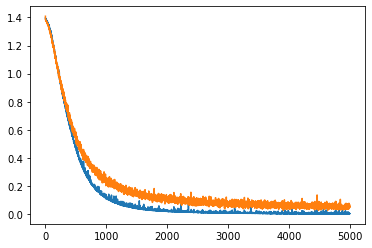

1


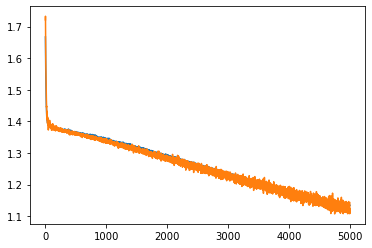

2


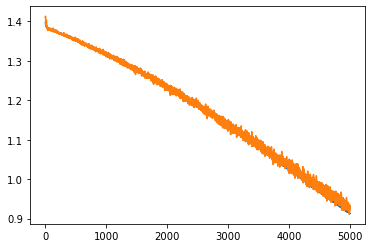

3


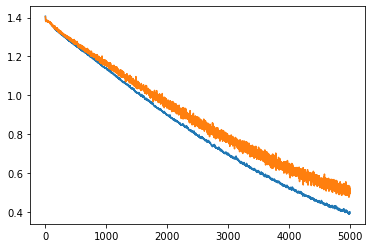

4


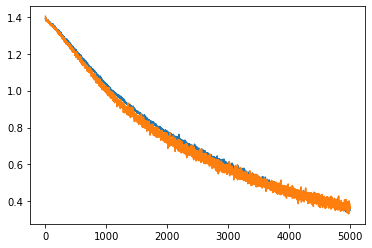

5


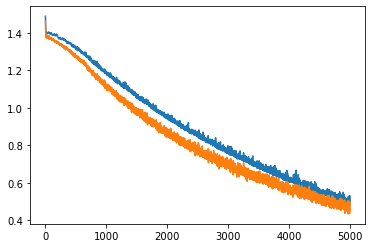

In [25]:
for i in range(6):
    curba1 = datos[datos.index == i]['LssVal'].tolist()
    curba2 = datos[datos.index == i]['LssTrain'].tolist()
    print(i)
    plt.plot(curba1[0])
    plt.plot(curba2[0])
    plt.show()

0


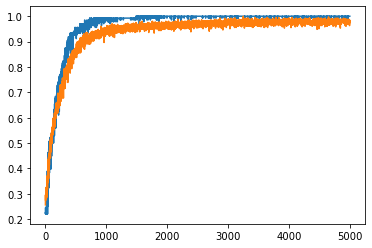

1


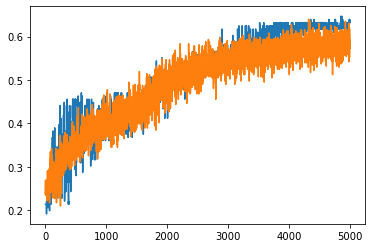

2


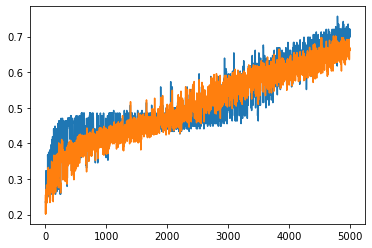

3


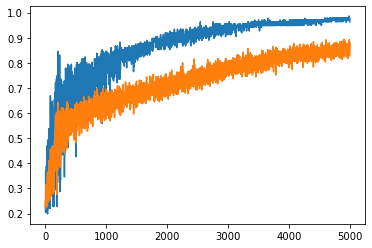

4


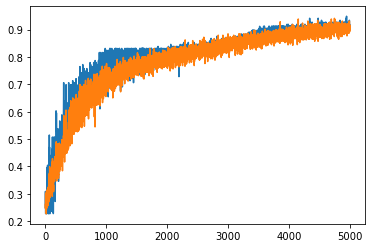

5


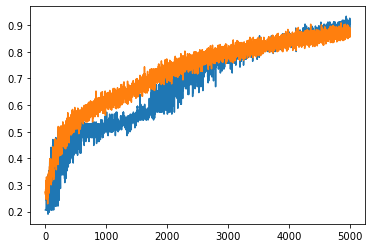

In [26]:
for i in range(6):
    curba1 = datos[datos.index == i]['AccVal'].tolist()
    curba2 = datos[datos.index == i]['AccTrain'].tolist()
    print(i)
    plt.plot(curba1[0])
    plt.plot(curba2[0])
    plt.show()

In [27]:
df1=pd.read_csv('Muestras/PruebaAgena.csv')

cambios=df1[df1['Tiempo']=='Order'].index.tolist()

contador = 0
x= []
y=[]
for i in cambios:
    gesto1=df1[(df1.index>=i-300)&(df1.index<i)].astype(int)
    gesto1 = gesto1.to_numpy()

    m=np.fft.rfft(gesto1[:,2:8],axis=0)
    f=30
    ones=np.ones(f)
    zeros=np.zeros(m.shape[0]-f)
    c=np.concatenate((ones,zeros))
    clean=m*c.reshape(m.shape[0],1)
    m=np.fft.irfft(clean,axis=0)
    x.append(m)

#   x.append(gesto1[:,2:8])

y=[1,1,1,1,1,3,3,3,3,3,2,2,2,2,2,0,0,0,0,0,1,1,1,1,1,3,3,3,3,3,2,2,2,2,2,0,0,0,0,0,1,1,1,1,1,3,3,3,3,3,2,2,2,2,2,0,0,0,0,0]
x = np.array(x)
y = np.array(y)
x = (x+32762)/65536
print(x.shape)

(60, 300, 6)


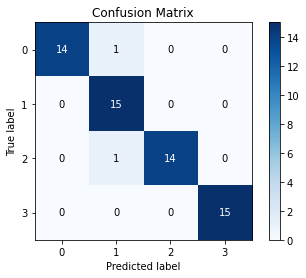

In [31]:
model =  tf.keras.models.load_model('./modelos/modelo_bs10_sf100_nf30.h5')
test_preds = model.predict(x).argmax(axis=1)
plot_confusion_matrix(y, test_preds, normalize=False)

In [29]:
test_preds[50:60]

array([2, 1, 2, 2, 2, 0, 0, 0, 0, 1], dtype=int64)

In [30]:
model.predict(x[50:60,:,:])

array([[2.6838221e-05, 7.7849333e-12, 9.9997318e-01, 3.0765865e-12],
       [5.2505875e-08, 9.9592257e-01, 4.8175029e-06, 4.0725735e-03],
       [3.4799597e-09, 6.8992995e-06, 9.9999309e-01, 4.0493009e-09],
       [9.1176951e-14, 4.8950410e-11, 1.0000000e+00, 4.6391901e-12],
       [3.5393747e-08, 2.8607002e-13, 1.0000000e+00, 5.2913931e-09],
       [9.9912590e-01, 6.7231724e-12, 8.7096944e-04, 3.1523898e-06],
       [9.9927205e-01, 5.0261562e-10, 6.9247681e-04, 3.5556819e-05],
       [9.9992895e-01, 2.9959290e-13, 2.8155215e-05, 4.2894659e-05],
       [9.9928647e-01, 3.6544967e-05, 6.6572661e-04, 1.1155731e-05],
       [2.2841117e-01, 7.7041149e-01, 3.5850529e-04, 8.1875070e-04]],
      dtype=float32)